# Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm



from glob import glob
from itertools import product
from itertools import combinations

import torch
from torch.utils.data import Dataset
from torchvision import transforms, utils
from torch.utils.data import DataLoader
from torch.utils.data.sampler import BatchSampler


import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, f1_score, precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV


import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


from IPython.display import clear_output



# Загрузка и предобработка данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# data = pd.read_excel("/content/drive/MyDrive/NeuralNetSch/PeakToPeak_P300_all_diff.xlsx")
data = pd.read_excel("Data/PeakToPeak_P300_all_diff.xlsx")
x = data.drop(['Name', "Diagnosis"], axis=1)
y = data["Diagnosis"]
x_np = np.array(x)
y_np = np.array(y)

Mounted at /content/drive


In [ ]:
classes = ['0', '1'] # 0 - control, 1 - shz
colors = ['#1f77b4', '#ff7f0e']

In [ ]:
from sklearn.preprocessing import StandardScaler
def split_and_norm_data(x, y, random_state):
  stScaler = StandardScaler()
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=random_state, stratify = y)
  stScaler.fit(x_train)
  x_train = stScaler.transform(x_train)
  x_test = stScaler.transform(x_test)
  return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = split_and_norm_data(x_np, y_np, random_state = 5)
print(f'Размер x_train = {x_train.shape}, размер x_test = {x_test.shape}')

Размер x_train = (22, 26), размер x_test = (10, 26)


In [ ]:
transform = torch.from_numpy

# Функция для обучения

In [ ]:
def fit(train_loader, val_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, train_dataset = None, metrics=[],
        start_epoch=0):
    """
    Loaders, model, loss function and metrics should work together for a given task,
    i.e. The model should be able to process data output of loaders,
    loss function should process target output of loaders and outputs from the model

    Examples: Classification: batch loader, classification model, NLL loss, accuracy metric
    Siamese network: Siamese loader, siamese model, contrastive loss
    Online triplet learning: batch loader, embedding model, online triplet loss
    """

    losses_train = []
    losses_val = []

    embeddings_for_viz = []
    labels_for_viz = []

    if train_dataset != None:
      all_train_data = DataLoader(train_dataset, batch_size = len(x_train), shuffle = False)


    for epoch in range(0, start_epoch):
        scheduler.step()

    for epoch in range(start_epoch, n_epochs):
        scheduler.step()

        # Train stage
        train_loss, metrics = train_epoch(train_loader, model, loss_fn, optimizer, cuda, log_interval, metrics)
        losses_train.append(train_loss)
        message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss)
        for metric in metrics:
            message += '\t{}: {}'.format(metric.name(), metric.value())

        val_loss, metrics = test_epoch(val_loader, model, loss_fn, cuda, metrics)
        val_loss /= len(val_loader)

        losses_val.append(val_loss)

        message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f}'.format(epoch + 1, n_epochs,
                                                                                 val_loss)
        for metric in metrics:
            message += '\t{}: {}'.format(metric.name(), metric.value())

        print(message)

        if train_dataset != None:
          with torch.no_grad():
            model.eval()
            embed = np.zeros((len(all_train_data.dataset), 16))
            labels = np.zeros(len(all_train_data.dataset))
            k = 0
            for x, y in all_train_data:
                if cuda:
                    x = x.cuda()
                embed[k:k+len(x)] = model.get_embedding(x).data.cpu().numpy()
                labels[k:k+len(x)] = y.numpy()
                k += len(x)

          embeddings_for_viz.append(embed)
          labels_for_viz.append(labels)


    return losses_train, losses_val, (embeddings_for_viz,labels_for_viz)


def train_epoch(train_loader, model, loss_fn, optimizer, cuda, log_interval, metrics):
    for metric in metrics:
        metric.reset()

    model.train()
    losses = []
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        target = target if len(target) > 0 else None
        if not type(data) in (tuple, list):
            data = (data,)
        if cuda:
            data = tuple(d.cuda() for d in data)
            if target is not None:
                target = target.cuda()


        optimizer.zero_grad()
        outputs = model(*data)

        if type(outputs) not in (tuple, list):
            outputs = (outputs,)

        loss_inputs = outputs
        if target is not None:
            target = (target,)
            loss_inputs += target

        loss_outputs = loss_fn(*loss_inputs)
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        for metric in metrics:
            metric(outputs, target, loss_outputs)

        if batch_idx % log_interval == 0:
            message = 'Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx * len(data[0]), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.mean(losses))
            for metric in metrics:
                message += '\t{}: {}'.format(metric.name(), metric.value())

            print(message)
            losses = []

    total_loss /= (batch_idx + 1)
    return total_loss, metrics


def test_epoch(val_loader, model, loss_fn, cuda, metrics):
    with torch.no_grad():
        for metric in metrics:
            metric.reset()
        model.eval()
        val_loss = 0
        for batch_idx, (data, target) in enumerate(val_loader):
            target = target if len(target) > 0 else None
            if not type(data) in (tuple, list):
                data = (data,)
            if cuda:
                data = tuple(d.cuda() for d in data)
                if target is not None:
                    target = target.cuda()

            outputs = model(*data)

            if type(outputs) not in (tuple, list):
                outputs = (outputs,)
            loss_inputs = outputs
            if target is not None:
                target = (target,)
                loss_inputs += target

            loss_outputs = loss_fn(*loss_inputs)
            loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
            val_loss += loss.item()

            for metric in metrics:
                metric(outputs, target, loss_outputs)

    return val_loss, metrics

# Датасет и батчСамплер для обучения

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data=None, targets = None, transform=None, classes = None):
        self.data = data #numpy array
        self.targets = targets #nympy array
        self.transform = transform
        self.classes = classes

    def __getitem__(self, index):
        x = self.transform(self.data[index]).to(torch.float32)
        y = self.targets[index]
        return x, y

    def __len__(self):
        return len(self.data)

In [ ]:
class BalancedBatchSampler(BatchSampler):
    """
    BatchSampler - from a MNIST-like dataset, samples n_classes and within these classes samples n_samples.
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, labels, classes, n_classes, n_samples):
        self.labels = labels
        self.labels_set = list(map(int,classes))
        self.label_to_indices = {label: np.where(self.labels == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size

# Отбор триплетов

In [ ]:
def pdist(vectors):
    distance_matrix = -2 * vectors.mm(torch.t(vectors)) + vectors.pow(2).sum(dim=1).view(1, -1) + vectors.pow(2).sum(
        dim=1).view(-1, 1)
    return distance_matrix


def hardest_negative(loss_values):
    hard_negative = np.argmax(loss_values)
    return hard_negative if loss_values[hard_negative] > 0 else None


def random_hard_negative(loss_values):
    hard_negatives = np.where(loss_values > 0)[0]
    return np.random.choice(hard_negatives) if len(hard_negatives) > 0 else None


def semihard_negative(loss_values, margin):
    semihard_negatives = np.where(np.logical_and(loss_values < margin, loss_values > 0))[0]
    return np.random.choice(semihard_negatives) if len(semihard_negatives) > 0 else None




class TripletSelector:
    """
    Implementation should return indices of anchors, positive and negative samples
    return np array of shape [N_triplets x 3]
    """

    def __init__(self):
        pass

    def get_triplets(self, embeddings, labels):
        raise NotImplementedError


class FunctionNegativeTripletSelector(TripletSelector):
    """
    For each positive pair, takes the hardest negative sample (with the greatest triplet loss value) to create a triplet
    Margin should match the margin used in triplet loss.
    negative_selection_fn should take array of loss_values for a given anchor-positive pair and all negative samples
    and return a negative index for that pair
    """

    def __init__(self, margin, negative_selection_fn, cpu=True):
        super(FunctionNegativeTripletSelector, self).__init__()
        self.cpu = cpu
        self.margin = margin
        self.negative_selection_fn = negative_selection_fn

    def get_triplets(self, embeddings, labels):
        if self.cpu:
            embeddings = embeddings.cpu()
        distance_matrix = pdist(embeddings)
        distance_matrix = distance_matrix.cpu()

        labels = labels.cpu().data.numpy()
        triplets = []

        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs
            anchor_positives = np.array(anchor_positives)

            ap_distances = distance_matrix[anchor_positives[:, 0], anchor_positives[:, 1]]
            for anchor_positive, ap_distance in zip(anchor_positives, ap_distances):
                loss_values = ap_distance - distance_matrix[torch.LongTensor(np.array([anchor_positive[0]])), torch.LongTensor(negative_indices)] + self.margin
                loss_values = loss_values.data.cpu().numpy()
                hard_negative = self.negative_selection_fn(loss_values)
                if hard_negative is not None:
                    hard_negative = negative_indices[hard_negative]
                    triplets.append([anchor_positive[0], anchor_positive[1], hard_negative])

        if len(triplets) == 0:
            triplets.append([anchor_positive[0], anchor_positive[1], negative_indices[0]])

        triplets = np.array(triplets)

        return torch.LongTensor(triplets)


def HardestNegativeTripletSelector(margin, cpu=False):
    return FunctionNegativeTripletSelector(margin=margin,
                                           negative_selection_fn=hardest_negative,
                                           cpu=cpu)


def RandomNegativeTripletSelector(margin, cpu=False):
    return FunctionNegativeTripletSelector(margin=margin,
                                           negative_selection_fn=random_hard_negative,
                                           cpu=cpu)


def SemihardNegativeTripletSelector(margin, cpu=False):
    return FunctionNegativeTripletSelector(margin=margin,
                                           negative_selection_fn=lambda x: semihard_negative(x, margin),
                                           cpu=cpu)

# Метрика подсчета ненулевых триптелов

In [ ]:
class Metric:
    def __init__(self):
        pass

    def __call__(self, outputs, target, loss):
        raise NotImplementedError

    def reset(self):
        raise NotImplementedError

    def value(self):
        raise NotImplementedError

    def name(self):
        raise NotImplementedError


class AverageNonzeroTripletsMetric(Metric):
    '''
    Counts average number of nonzero triplets found in minibatches
    '''

    def __init__(self):
        self.values = []

    def __call__(self, outputs, target, loss):
        self.values.append(loss[1])
        return self.value()

    def reset(self):
        self.values = []

    def value(self):
        return np.mean(self.values)

    def name(self):
        return 'Average nonzero triplets'

# Модель для получения эмбеддингов

In [ ]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers_stack = nn.Sequential(
            nn.Linear(26, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 16),

        )

    def forward(self, x):
        output = self.layers_stack(x)
        return output

    def get_embedding(self, x):
        return self.forward(x)


# Функция потерь

In [ ]:
class OnlineTripletLoss(nn.Module):
    """
    Online Triplets loss
    Takes a batch of embeddings and corresponding labels.
    Triplets are generated using triplet_selector object that take embeddings and targets and return indices of
    triplets
    """

    def __init__(self, margin, triplet_selector):
        super(OnlineTripletLoss, self).__init__()
        self.margin = margin
        self.triplet_selector = triplet_selector

    def forward(self, embeddings, target):

        triplets = self.triplet_selector.get_triplets(embeddings, target)

        if embeddings.is_cuda:
            triplets = triplets.cuda()

        ap_distances = (embeddings[triplets[:, 0]] - embeddings[triplets[:, 1]]).pow(2).sum(1)  # .pow(.5)
        an_distances = (embeddings[triplets[:, 0]] - embeddings[triplets[:, 2]]).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(ap_distances - an_distances + self.margin)

        return losses.mean(), len(triplets)

# Пример обучения

In [ ]:
train_dataset = CustomDataset(data = x_train, targets = y_train, transform = transform, classes = classes)
test_dataset = CustomDataset(data = x_test, targets = y_test, transform = transform, classes = classes)

In [ ]:
train_batch_sampler = BalancedBatchSampler(train_dataset.targets, classes = classes, n_classes=2, n_samples=9)
test_batch_sampler = BalancedBatchSampler(test_dataset.targets, classes = classes, n_classes=2, n_samples=4)

cuda = torch.cuda.is_available()

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))
lr = 1e-3
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 40
log_interval = 50

In [ ]:
train_l, val_l, viz = fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, train_dataset, metrics=[AverageNonzeroTripletsMetric()])

Train: [0/22 (0%)]	Loss: 0.999849	Average nonzero triplets: 64.0
Epoch: 1/40. Train set: Average loss: 0.9998	Average nonzero triplets: 64.0
Epoch: 1/40. Validation set: Average loss: 0.9991	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.999215	Average nonzero triplets: 64.0
Epoch: 2/40. Train set: Average loss: 0.9992	Average nonzero triplets: 64.0
Epoch: 2/40. Validation set: Average loss: 0.9967	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.997945	Average nonzero triplets: 64.0
Epoch: 3/40. Train set: Average loss: 0.9979	Average nonzero triplets: 64.0
Epoch: 3/40. Validation set: Average loss: 0.9924	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.993157	Average nonzero triplets: 64.0
Epoch: 4/40. Train set: Average loss: 0.9932	Average nonzero triplets: 64.0
Epoch: 4/40. Validation set: Average loss: 0.9839	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.995208	Average nonzero triplets: 64.0
Epoch: 5/40. Train set: Average loss: 0.9952	Av

In [ ]:
def plot_embeddings(embeddings, targets, classes, xlim=None, ylim=None):
    plt.figure(figsize=(5,5))
    for i in range(len(classes)):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(classes, loc='upper left')

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 16))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for x, y in dataloader:
            if cuda:
                x = x.cuda()
            embeddings[k:k+len(x)] = model.get_embedding(x).data.cpu().numpy()
            labels[k:k+len(x)] = y.numpy()
            k += len(x)
    return embeddings, labels

In [ ]:
train_ = DataLoader(train_dataset, batch_size = len(x_train), shuffle = False)
test_ =  DataLoader(test_dataset, batch_size = len(x_test), shuffle = False)

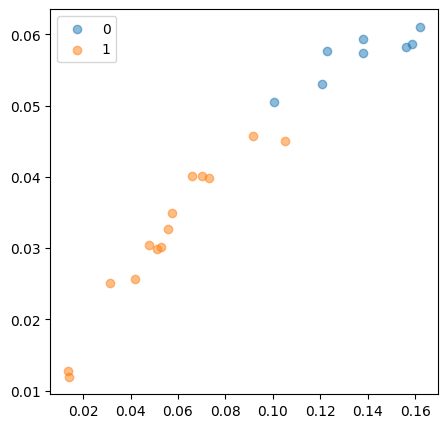

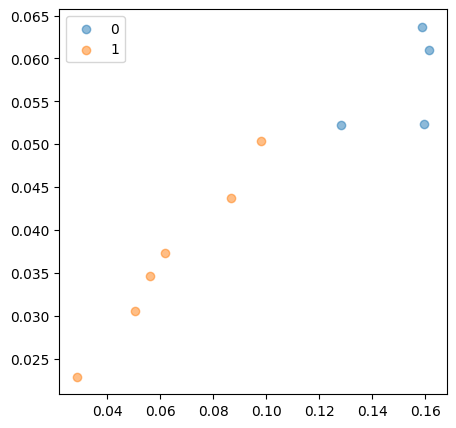

In [ ]:
train_embeddings_otl, train_labels_otl = extract_embeddings(train_, model)
plot_embeddings(train_embeddings_otl, train_labels_otl, classes = classes)
val_embeddings_otl, val_labels_otl = extract_embeddings(test_, model)
plot_embeddings(val_embeddings_otl, val_labels_otl, classes = classes)

## Визуализация процесса обучения

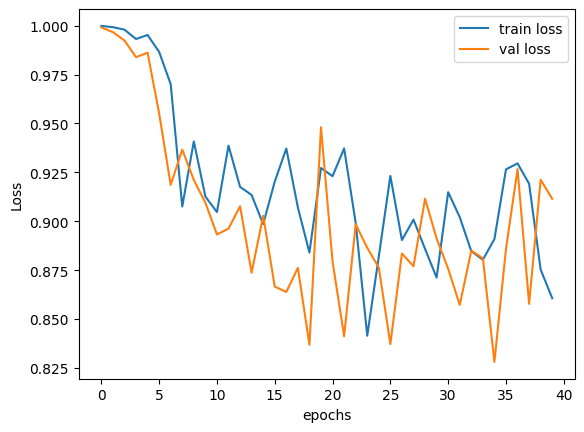

In [ ]:
plt.plot(train_l)
plt.plot(val_l)
plt.legend(['train loss', 'val loss'])
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.show()

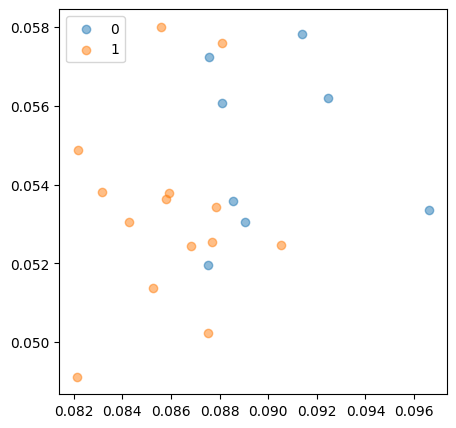

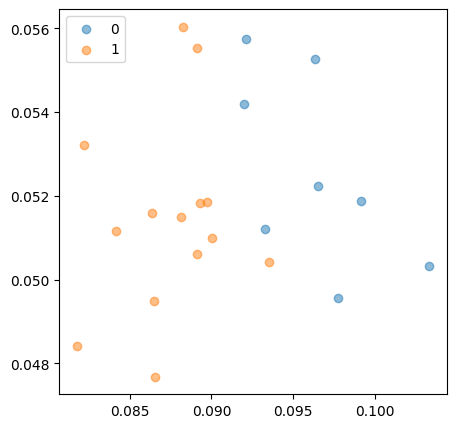

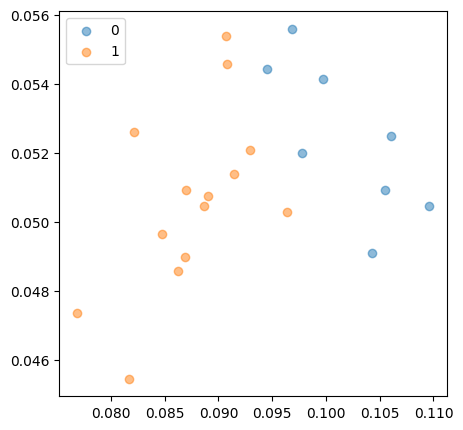

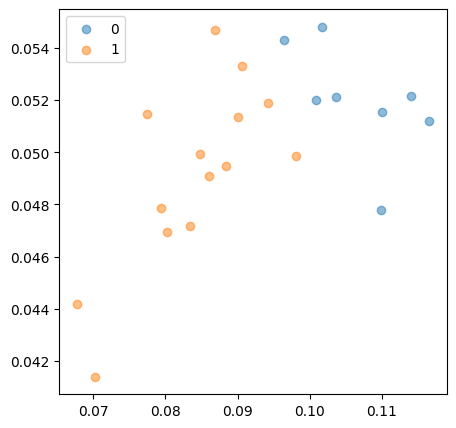

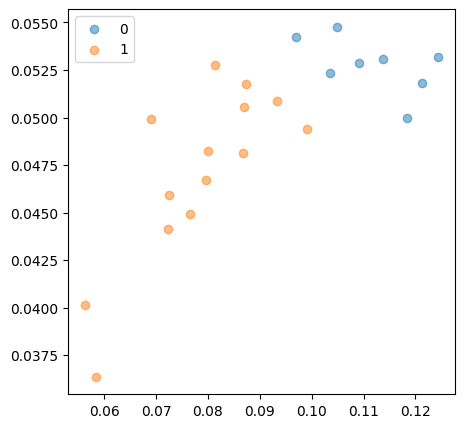

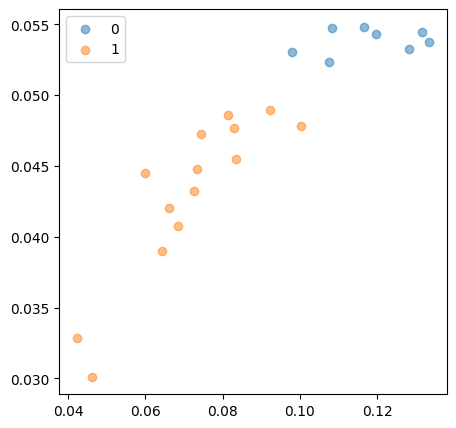

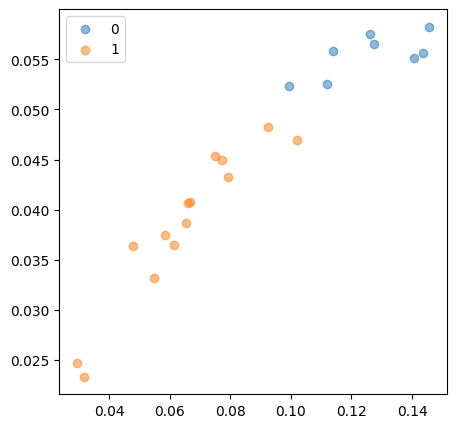

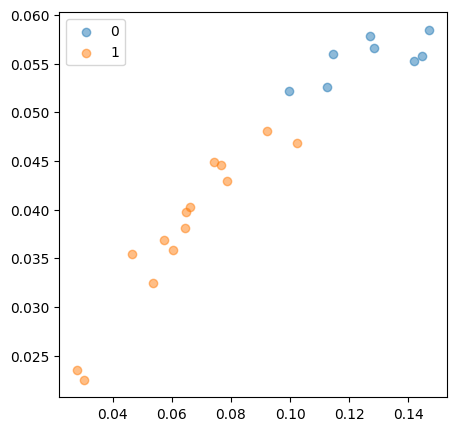

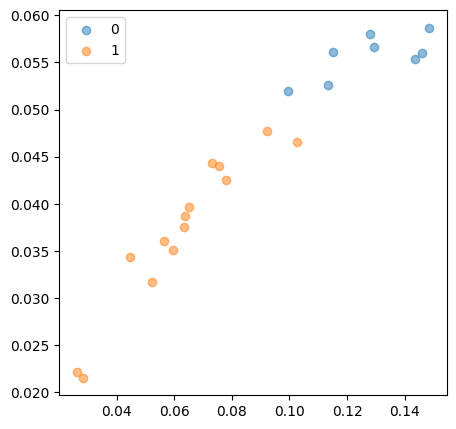

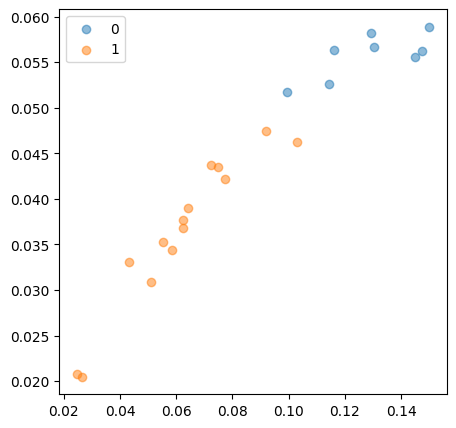

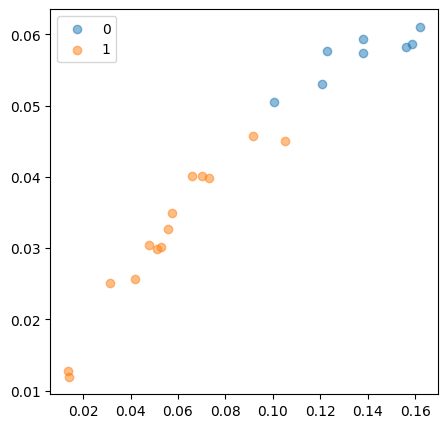

In [ ]:
for i in range(10):
  plot_embeddings(viz[0][i], viz[1][i], classes = classes)
plot_embeddings(viz[0][39], viz[1][39], classes = classes)

In [ ]:
x_train_, y_train_ = next(iter(train_))
x_test_, y_test_ = next(iter(test_))

emb_train = model(x_train_.to(torch.float32)).detach().numpy()
emb_test = model(x_test_.to(torch.float32)).detach().numpy()

In [ ]:
parameters = {'n_neighbors':range(3,10,1)}

knn = KNeighborsClassifier()
clf_knn = GridSearchCV(knn, parameters)
clf_knn.fit(emb_train, y_train_)
clf = KNeighborsClassifier(n_neighbors = clf_knn.best_params_['n_neighbors'])
clf.fit(emb_train, y_train_)
print(classification_report(clf.predict(emb_test), y_test_))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.86      0.92         7

    accuracy                           0.90        10
   macro avg       0.88      0.93      0.89        10
weighted avg       0.93      0.90      0.90        10



## Shap

# Обучение и оценка на разных сидах

In [ ]:
def train_and_eval (x, y, n_states = 100):

    train_losses = []
    val_losses = []

    f1_scores = []
    recall_scores = []
    precision_scores = []

    for i in range(n_states):

        x_train, x_test, y_train, y_test = split_and_norm_data(x, y, random_state = i)

        train_dataset = CustomDataset(data = x_train, targets = y_train, transform = transform, classes = classes)
        test_dataset = CustomDataset(data = x_test, targets = y_test, transform = transform, classes = classes)

        train_batch_sampler = BalancedBatchSampler(train_dataset.targets, classes = classes, n_classes=2, n_samples=9)
        test_batch_sampler = BalancedBatchSampler(test_dataset.targets, classes = classes, n_classes=2, n_samples=4)

        cuda = torch.cuda.is_available()

        kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
        online_train_loader = DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
        online_test_loader = DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

        margin = 1.
        embedding_net = EmbeddingNet()
        model = embedding_net
        if cuda:
            model.cuda()
        loss_fn = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))
        lr = 1e-3
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
        n_epochs = 50
        log_interval = 50
        tr_loss, val_loss, _ = fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])
        train_losses.append(tr_loss)
        val_losses.append(val_loss)

        prec, rec, f = eval(model, x_train, x_test, y_train, y_test)
        f1_scores.append(f)
        recall_scores.append(rec)
        precision_scores.append(prec)


    return train_losses, val_losses, classification_report_on_diff_seeds(f1_scores, recall_scores, precision_scores)



from sklearn.svm import SVC


def eval(emb_model, x_train, x_test, y_train, y_test):
    train_dataset = CustomDataset(data = x_train, targets = y_train, transform = transform, classes = classes)
    test_dataset = CustomDataset(data = x_test, targets = y_test, transform = transform, classes = classes)
    train_ = DataLoader(train_dataset, batch_size = len(x_train), shuffle = False)
    test_ =  DataLoader(test_dataset, batch_size = len(x_test), shuffle = False)
    x_train_, y_train_ = next(iter(train_))
    x_test_, y_test_ = next(iter(test_))
    emb_train = emb_model(x_train_.to(torch.float32)).detach().numpy()
    emb_test = emb_model(x_test_.to(torch.float32)).detach().numpy()

    parameters = {'n_neighbors':range(3,10,1)}
    knn = KNeighborsClassifier()
    param_knn = GridSearchCV(knn, parameters)
    param_knn.fit(emb_train, y_train_)
    clf = KNeighborsClassifier(n_neighbors = param_knn.best_params_['n_neighbors'])
    clf.fit(emb_train, y_train_)
    y_pred = clf.predict(emb_test)

    prec, rec, f, sup = precision_recall_fscore_support (y_pred, y_test_)
    return prec, rec, f


def classification_report_on_diff_seeds (f1_scores, recall_scores, precision_scores):
      df = pd.concat(axis=1, ignore_index=False, objs=[
          pd.DataFrame.from_dict({'classes': [0, 1, 'average']}),
          pd.DataFrame.from_dict({'precision_mean': np.append(np.mean(precision_scores, axis = 0), np.mean(precision_scores))}),
          # pd.DataFrame.from_dict({'precision_std': np.std(precision_scores, axis = 0)}),
          pd.DataFrame.from_dict({'recall_mean': np.append(np.mean(recall_scores, axis = 0), np.mean(recall_scores))}),
          # pd.DataFrame.from_dict({'recall_std': np.std(recall_scores, axis = 0)}),
          pd.DataFrame.from_dict({'f1_mean': np.append(np.mean(f1_scores, axis = 0), np.mean(f1_scores))}),
          # pd.DataFrame.from_dict({'f1_std': np.std(f1_scores, axis = 0)})
          ])
      return df

In [ ]:
train_loss, val_loss, results = train_and_eval(x_np, y_np)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999818	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 0.9998	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9998	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.999336	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9993	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 1.0002	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.996895	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9969	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9981	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.990706	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9907	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9974	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.984013	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9840	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: 5/50. Train set: Average loss: 0.9824	Average nonzero triplets: 64.0
Epoch: 5/50. Validation set: Average loss: 0.9946	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.972215	Average nonzero triplets: 64.0
Epoch: 6/50. Train set: Average loss: 0.9722	Average nonzero triplets: 64.0
Epoch: 6/50. Validation set: Average loss: 0.9804	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.959332	Average nonzero triplets: 64.0
Epoch: 7/50. Train set: Average loss: 0.9593	Average nonzero triplets: 64.0
Epoch: 7/50. Validation set: Average loss: 0.9752	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.930433	Average nonzero triplets: 64.0
Epoch: 8/50. Train set: Average loss: 0.9304	Average nonzero triplets: 64.0
Epoch: 8/50. Validation set: Average loss: 0.9726	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.925690	Average nonzero triplets: 64.0
Epoch: 9/50. Train set: Average loss: 0.9257	Average nonzero triplets: 64.0
Epoch: 9/50. Validation set: Average

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999372	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 0.9994	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9970	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.996810	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9968	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9929	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.988920	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9889	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9798	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.971229	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9712	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9843	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.968292	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9683	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999828	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 0.9998	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9998	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.998422	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9984	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9972	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.996943	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9969	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9961	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.989072	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9891	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9929	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.984121	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9841	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.950847	Average nonzero triplets: 64.0
Epoch: 8/50. Train set: Average loss: 0.9508	Average nonzero triplets: 64.0
Epoch: 8/50. Validation set: Average loss: 0.9678	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.915897	Average nonzero triplets: 64.0
Epoch: 9/50. Train set: Average loss: 0.9159	Average nonzero triplets: 64.0
Epoch: 9/50. Validation set: Average loss: 0.9874	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.930303	Average nonzero triplets: 64.0
Epoch: 10/50. Train set: Average loss: 0.9303	Average nonzero triplets: 64.0
Epoch: 10/50. Validation set: Average loss: 0.9708	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.939628	Average nonzero triplets: 64.0
Epoch: 11/50. Train set: Average loss: 0.9396	Average nonzero triplets: 64.0
Epoch: 11/50. Validation set: Average loss: 0.9624	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.922522	Average nonzero triplets: 64.0
Epoch: 12/50. Train set: Average loss: 0.92

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999968	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 1.0000	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9996	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.999046	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9990	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9976	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.997749	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9977	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9932	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.994751	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9948	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9874	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.985491	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9855	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.938827	Average nonzero triplets: 64.0
Epoch: 8/50. Train set: Average loss: 0.9388	Average nonzero triplets: 64.0
Epoch: 8/50. Validation set: Average loss: 0.9602	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.946160	Average nonzero triplets: 64.0
Epoch: 9/50. Train set: Average loss: 0.9462	Average nonzero triplets: 64.0
Epoch: 9/50. Validation set: Average loss: 0.9131	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.927863	Average nonzero triplets: 64.0
Epoch: 10/50. Train set: Average loss: 0.9279	Average nonzero triplets: 64.0
Epoch: 10/50. Validation set: Average loss: 0.9443	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.922496	Average nonzero triplets: 64.0
Epoch: 11/50. Train set: Average loss: 0.9225	Average nonzero triplets: 64.0
Epoch: 11/50. Validation set: Average loss: 0.9300	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.925573	Average nonzero triplets: 64.0
Epoch: 12/50. Train set: Average loss: 0.92

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999804	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 0.9998	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9995	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.997933	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9979	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9982	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.997398	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9974	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9961	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.992796	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9928	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9823	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.983373	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9834	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: 9/50. Train set: Average loss: 0.8380	Average nonzero triplets: 64.0
Epoch: 9/50. Validation set: Average loss: 0.7534	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.876851	Average nonzero triplets: 64.0
Epoch: 10/50. Train set: Average loss: 0.8769	Average nonzero triplets: 64.0
Epoch: 10/50. Validation set: Average loss: 0.8115	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.918293	Average nonzero triplets: 64.0
Epoch: 11/50. Train set: Average loss: 0.9183	Average nonzero triplets: 64.0
Epoch: 11/50. Validation set: Average loss: 0.7812	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.881984	Average nonzero triplets: 64.0
Epoch: 12/50. Train set: Average loss: 0.8820	Average nonzero triplets: 64.0
Epoch: 12/50. Validation set: Average loss: 0.7077	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.901217	Average nonzero triplets: 64.0
Epoch: 13/50. Train set: Average loss: 0.9012	Average nonzero triplets: 64.0
Epoch: 13/50. Validation set:

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999779	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 0.9998	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9990	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.998929	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9989	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9974	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.994895	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9949	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9900	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.992506	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9925	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9756	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.980482	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9805	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.898166	Average nonzero triplets: 64.0
Epoch: 10/50. Train set: Average loss: 0.8982	Average nonzero triplets: 64.0
Epoch: 10/50. Validation set: Average loss: 0.9887	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.874847	Average nonzero triplets: 64.0
Epoch: 11/50. Train set: Average loss: 0.8748	Average nonzero triplets: 64.0
Epoch: 11/50. Validation set: Average loss: 0.9747	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.907279	Average nonzero triplets: 64.0
Epoch: 12/50. Train set: Average loss: 0.9073	Average nonzero triplets: 64.0
Epoch: 12/50. Validation set: Average loss: 0.9877	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.874128	Average nonzero triplets: 64.0
Epoch: 13/50. Train set: Average loss: 0.8741	Average nonzero triplets: 64.0
Epoch: 13/50. Validation set: Average loss: 0.9618	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.883647	Average nonzero triplets: 64.0
Epoch: 14/50. Train set: Average loss: 

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: 1/50. Train set: Average loss: 1.0000	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 1.0002	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.998856	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9989	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9992	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.998883	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9989	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 1.0023	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.991372	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9914	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9975	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.980540	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9805	Average nonzero triplets: 64.0
Epoch: 5/50. Validation set: Average

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.919664	Average nonzero triplets: 64.0
Epoch: 9/50. Train set: Average loss: 0.9197	Average nonzero triplets: 64.0
Epoch: 9/50. Validation set: Average loss: 0.9583	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.930094	Average nonzero triplets: 64.0
Epoch: 10/50. Train set: Average loss: 0.9301	Average nonzero triplets: 64.0
Epoch: 10/50. Validation set: Average loss: 0.9450	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.948572	Average nonzero triplets: 64.0
Epoch: 11/50. Train set: Average loss: 0.9486	Average nonzero triplets: 64.0
Epoch: 11/50. Validation set: Average loss: 1.0001	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.945508	Average nonzero triplets: 64.0
Epoch: 12/50. Train set: Average loss: 0.9455	Average nonzero triplets: 64.0
Epoch: 12/50. Validation set: Average loss: 0.9801	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.917879	Average nonzero triplets: 64.0
Epoch: 13/50. Train set: Average loss: 0.

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999713	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 0.9997	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9986	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.999302	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9993	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9979	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.993844	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9938	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9965	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.990362	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9904	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9763	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.981563	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9816	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 1.000124	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 1.0001	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9999	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.999785	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9998	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9996	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.998740	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9987	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9978	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.994458	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9945	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9982	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.985129	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9851	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999660	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 0.9997	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9995	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.998078	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9981	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 1.0003	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.995939	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9959	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9924	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.985815	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9858	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9821	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.974193	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9742	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999972	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 1.0000	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9999	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.998870	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9989	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9997	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.997788	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9978	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9945	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.992808	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9928	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9973	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.988449	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9884	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 1.000045	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 1.0000	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9998	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.999973	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 1.0000	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9994	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.999498	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9995	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9966	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.998856	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9989	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9930	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.993508	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9935	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999933	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 0.9999	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9998	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.999935	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9999	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9995	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.999187	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9992	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9986	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.997784	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9978	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9957	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.994334	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9943	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.994441	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9944	Average nonzero triplets: 64.0
Epoch: 5/50. Validation set: Average loss: 0.9975	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.982177	Average nonzero triplets: 64.0
Epoch: 6/50. Train set: Average loss: 0.9822	Average nonzero triplets: 64.0
Epoch: 6/50. Validation set: Average loss: 0.9922	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.973310	Average nonzero triplets: 64.0
Epoch: 7/50. Train set: Average loss: 0.9733	Average nonzero triplets: 64.0
Epoch: 7/50. Validation set: Average loss: 0.9894	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.953602	Average nonzero triplets: 64.0
Epoch: 8/50. Train set: Average loss: 0.9536	Average nonzero triplets: 64.0
Epoch: 8/50. Validation set: Average loss: 0.9968	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.951005	Average nonzero triplets: 64.0
Epoch: 9/50. Train set: Average loss: 0.9510	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999961	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 1.0000	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9996	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.998957	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9990	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 1.0007	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.996108	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9961	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9868	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.989345	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9893	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 1.0093	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.979382	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9794	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.886966	Average nonzero triplets: 64.0
Epoch: 8/50. Train set: Average loss: 0.8870	Average nonzero triplets: 64.0
Epoch: 8/50. Validation set: Average loss: 0.9938	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.866125	Average nonzero triplets: 64.0
Epoch: 9/50. Train set: Average loss: 0.8661	Average nonzero triplets: 64.0
Epoch: 9/50. Validation set: Average loss: 0.9644	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.864742	Average nonzero triplets: 64.0
Epoch: 10/50. Train set: Average loss: 0.8647	Average nonzero triplets: 64.0
Epoch: 10/50. Validation set: Average loss: 1.0124	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.881444	Average nonzero triplets: 64.0
Epoch: 11/50. Train set: Average loss: 0.8814	Average nonzero triplets: 64.0
Epoch: 11/50. Validation set: Average loss: 0.9487	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.862715	Average nonzero triplets: 64.0
Epoch: 12/50. Train set: Average loss: 0.86

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999337	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 0.9993	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9987	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.998373	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9984	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9964	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.994898	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9949	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9906	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.982001	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9820	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9796	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.988067	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9881	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.888155	Average nonzero triplets: 64.0
Epoch: 8/50. Train set: Average loss: 0.8882	Average nonzero triplets: 64.0
Epoch: 8/50. Validation set: Average loss: 0.8484	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.833565	Average nonzero triplets: 64.0
Epoch: 9/50. Train set: Average loss: 0.8336	Average nonzero triplets: 64.0
Epoch: 9/50. Validation set: Average loss: 0.7837	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.864135	Average nonzero triplets: 64.0
Epoch: 10/50. Train set: Average loss: 0.8641	Average nonzero triplets: 64.0
Epoch: 10/50. Validation set: Average loss: 0.8956	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.858997	Average nonzero triplets: 64.0
Epoch: 11/50. Train set: Average loss: 0.8590	Average nonzero triplets: 64.0
Epoch: 11/50. Validation set: Average loss: 0.8790	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.844778	Average nonzero triplets: 64.0
Epoch: 12/50. Train set: Average loss: 0.84

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999928	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 0.9999	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 1.0001	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.999699	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9997	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9995	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.998188	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9982	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9989	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.995934	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9959	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9975	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.990379	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9904	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 1.000193	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 1.0002	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9995	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.999821	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9998	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9991	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.997318	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9973	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9953	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.994359	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9944	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9923	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.992170	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9922	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: 9/50. Train set: Average loss: 0.8146	Average nonzero triplets: 64.0
Epoch: 9/50. Validation set: Average loss: 0.8825	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.874095	Average nonzero triplets: 64.0
Epoch: 10/50. Train set: Average loss: 0.8741	Average nonzero triplets: 64.0
Epoch: 10/50. Validation set: Average loss: 0.8734	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.867421	Average nonzero triplets: 64.0
Epoch: 11/50. Train set: Average loss: 0.8674	Average nonzero triplets: 64.0
Epoch: 11/50. Validation set: Average loss: 0.8729	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.847734	Average nonzero triplets: 64.0
Epoch: 12/50. Train set: Average loss: 0.8477	Average nonzero triplets: 64.0
Epoch: 12/50. Validation set: Average loss: 0.8273	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.836408	Average nonzero triplets: 64.0
Epoch: 13/50. Train set: Average loss: 0.8364	Average nonzero triplets: 64.0
Epoch: 13/50. Validation set:

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: 4/50. Train set: Average loss: 0.9947	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9911	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.991044	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9910	Average nonzero triplets: 64.0
Epoch: 5/50. Validation set: Average loss: 0.9824	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.984278	Average nonzero triplets: 64.0
Epoch: 6/50. Train set: Average loss: 0.9843	Average nonzero triplets: 64.0
Epoch: 6/50. Validation set: Average loss: 0.9602	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.974802	Average nonzero triplets: 64.0
Epoch: 7/50. Train set: Average loss: 0.9748	Average nonzero triplets: 64.0
Epoch: 7/50. Validation set: Average loss: 0.9331	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.932699	Average nonzero triplets: 64.0
Epoch: 8/50. Train set: Average loss: 0.9327	Average nonzero triplets: 64.0
Epoch: 8/50. Validation set: Average

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999962	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 1.0000	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9994	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.999368	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9994	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9990	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.996333	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9963	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9941	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.994971	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9950	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9919	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.979816	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9798	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: 9/50. Train set: Average loss: 0.8960	Average nonzero triplets: 64.0
Epoch: 9/50. Validation set: Average loss: 0.9792	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.927102	Average nonzero triplets: 64.0
Epoch: 10/50. Train set: Average loss: 0.9271	Average nonzero triplets: 64.0
Epoch: 10/50. Validation set: Average loss: 0.9822	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.896188	Average nonzero triplets: 64.0
Epoch: 11/50. Train set: Average loss: 0.8962	Average nonzero triplets: 64.0
Epoch: 11/50. Validation set: Average loss: 0.9263	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.879722	Average nonzero triplets: 64.0
Epoch: 12/50. Train set: Average loss: 0.8797	Average nonzero triplets: 64.0
Epoch: 12/50. Validation set: Average loss: 0.9580	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.886232	Average nonzero triplets: 64.0
Epoch: 13/50. Train set: Average loss: 0.8862	Average nonzero triplets: 64.0
Epoch: 13/50. Validation set:

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.976214	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9762	Average nonzero triplets: 64.0
Epoch: 5/50. Validation set: Average loss: 0.9958	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.972612	Average nonzero triplets: 64.0
Epoch: 6/50. Train set: Average loss: 0.9726	Average nonzero triplets: 64.0
Epoch: 6/50. Validation set: Average loss: 0.9956	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.912635	Average nonzero triplets: 64.0
Epoch: 7/50. Train set: Average loss: 0.9126	Average nonzero triplets: 64.0
Epoch: 7/50. Validation set: Average loss: 0.9292	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.875261	Average nonzero triplets: 64.0
Epoch: 8/50. Train set: Average loss: 0.8753	Average nonzero triplets: 64.0
Epoch: 8/50. Validation set: Average loss: 0.8999	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.887259	Average nonzero triplets: 64.0
Epoch: 9/50. Train set: Average loss: 0.8873	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999546	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 0.9995	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 1.0002	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.997753	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9978	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9999	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.994149	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9941	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 1.0005	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.976999	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9770	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 1.0025	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.970920	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9709	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999931	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 0.9999	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 1.0001	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.999500	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9995	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 1.0004	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.998169	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9982	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 1.0000	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.995316	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9953	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9970	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.988756	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9888	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999840	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 0.9998	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9991	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.999305	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9993	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9984	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.997138	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9971	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9928	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.990546	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9905	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9885	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.988785	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9888	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999747	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 0.9997	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9984	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.998569	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9986	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9928	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.991664	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9917	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9858	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.985267	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9853	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9777	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.969161	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9692	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999754	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 0.9998	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9999	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.998212	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9982	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9998	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.991616	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9916	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9973	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.981067	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9811	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9844	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.966815	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9668	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 1.000016	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 1.0000	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9995	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.998964	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9990	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9989	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.998106	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9981	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9984	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.988234	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9882	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9963	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.982582	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9826	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.993323	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9933	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9920	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.974923	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9749	Average nonzero triplets: 64.0
Epoch: 5/50. Validation set: Average loss: 0.9844	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.972463	Average nonzero triplets: 64.0
Epoch: 6/50. Train set: Average loss: 0.9725	Average nonzero triplets: 64.0
Epoch: 6/50. Validation set: Average loss: 0.9525	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.931839	Average nonzero triplets: 64.0
Epoch: 7/50. Train set: Average loss: 0.9318	Average nonzero triplets: 64.0
Epoch: 7/50. Validation set: Average loss: 0.9523	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.873058	Average nonzero triplets: 64.0
Epoch: 8/50. Train set: Average loss: 0.8731	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999933	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 0.9999	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9984	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.999492	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9995	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9947	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.997720	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9977	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9929	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.993570	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9936	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9801	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.986272	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9863	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.947155	Average nonzero triplets: 64.0
Epoch: 9/50. Train set: Average loss: 0.9472	Average nonzero triplets: 64.0
Epoch: 9/50. Validation set: Average loss: 0.9237	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.936062	Average nonzero triplets: 64.0
Epoch: 10/50. Train set: Average loss: 0.9361	Average nonzero triplets: 64.0
Epoch: 10/50. Validation set: Average loss: 0.9450	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.929799	Average nonzero triplets: 64.0
Epoch: 11/50. Train set: Average loss: 0.9298	Average nonzero triplets: 64.0
Epoch: 11/50. Validation set: Average loss: 0.9376	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.902215	Average nonzero triplets: 64.0
Epoch: 12/50. Train set: Average loss: 0.9022	Average nonzero triplets: 64.0
Epoch: 12/50. Validation set: Average loss: 0.9192	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.909026	Average nonzero triplets: 64.0
Epoch: 13/50. Train set: Average loss: 0.

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999939	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 0.9999	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9999	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.999305	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9993	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9993	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.998068	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9981	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9977	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.994523	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9945	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9963	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.982473	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9825	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: 9/50. Train set: Average loss: 0.8300	Average nonzero triplets: 64.0
Epoch: 9/50. Validation set: Average loss: 0.8262	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.855689	Average nonzero triplets: 64.0
Epoch: 10/50. Train set: Average loss: 0.8557	Average nonzero triplets: 64.0
Epoch: 10/50. Validation set: Average loss: 0.8077	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.893669	Average nonzero triplets: 64.0
Epoch: 11/50. Train set: Average loss: 0.8937	Average nonzero triplets: 64.0
Epoch: 11/50. Validation set: Average loss: 0.8435	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.838303	Average nonzero triplets: 64.0
Epoch: 12/50. Train set: Average loss: 0.8383	Average nonzero triplets: 64.0
Epoch: 12/50. Validation set: Average loss: 0.8691	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.805669	Average nonzero triplets: 64.0
Epoch: 13/50. Train set: Average loss: 0.8057	Average nonzero triplets: 64.0
Epoch: 13/50. Validation set:

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999872	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 0.9999	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9992	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.999991	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 1.0000	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9970	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.998619	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9986	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9926	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.995368	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9954	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9860	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.989187	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9892	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.863650	Average nonzero triplets: 64.0
Epoch: 10/50. Train set: Average loss: 0.8636	Average nonzero triplets: 64.0
Epoch: 10/50. Validation set: Average loss: 0.8895	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.841298	Average nonzero triplets: 64.0
Epoch: 11/50. Train set: Average loss: 0.8413	Average nonzero triplets: 64.0
Epoch: 11/50. Validation set: Average loss: 0.9032	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.868499	Average nonzero triplets: 64.0
Epoch: 12/50. Train set: Average loss: 0.8685	Average nonzero triplets: 64.0
Epoch: 12/50. Validation set: Average loss: 0.8654	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.878641	Average nonzero triplets: 64.0
Epoch: 13/50. Train set: Average loss: 0.8786	Average nonzero triplets: 64.0
Epoch: 13/50. Validation set: Average loss: 0.9035	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.880857	Average nonzero triplets: 64.0
Epoch: 14/50. Train set: Average loss: 

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999216	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9992	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9893	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.997575	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9976	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9822	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.992612	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9926	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9811	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.987872	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9879	Average nonzero triplets: 64.0
Epoch: 5/50. Validation set: Average loss: 0.9506	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.979239	Average nonzero triplets: 64.0
Epoch: 6/50. Train set: Average loss: 0.9792	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999391	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 0.9994	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9996	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.997944	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9979	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9975	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.993548	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9935	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9961	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.987454	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9875	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9916	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.975229	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9752	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999739	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 0.9997	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9997	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.997947	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9979	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9994	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.993535	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9935	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9942	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.988260	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9883	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9930	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.977851	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9779	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.860845	Average nonzero triplets: 64.0
Epoch: 11/50. Train set: Average loss: 0.8608	Average nonzero triplets: 64.0
Epoch: 11/50. Validation set: Average loss: 0.9343	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.796799	Average nonzero triplets: 64.0
Epoch: 12/50. Train set: Average loss: 0.7968	Average nonzero triplets: 64.0
Epoch: 12/50. Validation set: Average loss: 0.9106	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.883109	Average nonzero triplets: 64.0
Epoch: 13/50. Train set: Average loss: 0.8831	Average nonzero triplets: 64.0
Epoch: 13/50. Validation set: Average loss: 0.9183	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.794002	Average nonzero triplets: 64.0
Epoch: 14/50. Train set: Average loss: 0.7940	Average nonzero triplets: 64.0
Epoch: 14/50. Validation set: Average loss: 0.8377	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.793998	Average nonzero triplets: 64.0
Epoch: 15/50. Train set: Average loss: 

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.995536	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9955	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9900	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.994126	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9941	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9799	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.985187	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9852	Average nonzero triplets: 64.0
Epoch: 5/50. Validation set: Average loss: 0.9660	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.979248	Average nonzero triplets: 64.0
Epoch: 6/50. Train set: Average loss: 0.9792	Average nonzero triplets: 64.0
Epoch: 6/50. Validation set: Average loss: 0.9127	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.944493	Average nonzero triplets: 64.0
Epoch: 7/50. Train set: Average loss: 0.9445	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999805	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 0.9998	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9991	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.998986	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9990	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9989	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.996795	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9968	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9934	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.991084	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9911	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9929	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.986385	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9864	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999011	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9990	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9959	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.995426	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9954	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9912	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.991063	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9911	Average nonzero triplets: 64.0
Epoch: 5/50. Validation set: Average loss: 0.9760	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.971164	Average nonzero triplets: 64.0
Epoch: 6/50. Train set: Average loss: 0.9712	Average nonzero triplets: 64.0
Epoch: 6/50. Validation set: Average loss: 0.9853	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.969323	Average nonzero triplets: 64.0
Epoch: 7/50. Train set: Average loss: 0.9693	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999380	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 0.9994	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9983	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.994397	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9944	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9990	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.982063	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9821	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 1.0040	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.961432	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9614	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9906	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.956224	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9562	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999959	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 1.0000	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 1.0000	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.999138	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9991	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9992	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.996116	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9961	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9940	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.997611	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9976	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9903	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.993362	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9934	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.987717	Average nonzero triplets: 64.0
Epoch: 6/50. Train set: Average loss: 0.9877	Average nonzero triplets: 64.0
Epoch: 6/50. Validation set: Average loss: 0.9895	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.979134	Average nonzero triplets: 64.0
Epoch: 7/50. Train set: Average loss: 0.9791	Average nonzero triplets: 64.0
Epoch: 7/50. Validation set: Average loss: 0.9705	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.952240	Average nonzero triplets: 64.0
Epoch: 8/50. Train set: Average loss: 0.9522	Average nonzero triplets: 64.0
Epoch: 8/50. Validation set: Average loss: 0.9836	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.927285	Average nonzero triplets: 64.0
Epoch: 9/50. Train set: Average loss: 0.9273	Average nonzero triplets: 64.0
Epoch: 9/50. Validation set: Average loss: 0.9866	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.920259	Average nonzero triplets: 64.0
Epoch: 10/50. Train set: Average loss: 0.9203	A

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999951	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 1.0000	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9994	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.999214	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9992	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9992	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.997158	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9972	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 1.0011	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.991841	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9918	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 1.0029	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.989732	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9897	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: 6/50. Train set: Average loss: 0.9847	Average nonzero triplets: 64.0
Epoch: 6/50. Validation set: Average loss: 0.9894	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.963410	Average nonzero triplets: 64.0
Epoch: 7/50. Train set: Average loss: 0.9634	Average nonzero triplets: 64.0
Epoch: 7/50. Validation set: Average loss: 0.9833	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.938917	Average nonzero triplets: 64.0
Epoch: 8/50. Train set: Average loss: 0.9389	Average nonzero triplets: 64.0
Epoch: 8/50. Validation set: Average loss: 0.9595	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.947949	Average nonzero triplets: 64.0
Epoch: 9/50. Train set: Average loss: 0.9479	Average nonzero triplets: 64.0
Epoch: 9/50. Validation set: Average loss: 1.0261	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.957235	Average nonzero triplets: 64.0
Epoch: 10/50. Train set: Average loss: 0.9572	Average nonzero triplets: 64.0
Epoch: 10/50. Validation set: Avera

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999921	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 0.9999	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9997	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.999036	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9990	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9994	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.996475	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9965	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9957	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.995933	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9959	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9965	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.978257	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9783	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.926012	Average nonzero triplets: 64.0
Epoch: 9/50. Train set: Average loss: 0.9260	Average nonzero triplets: 64.0
Epoch: 9/50. Validation set: Average loss: 0.9563	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.885861	Average nonzero triplets: 64.0
Epoch: 10/50. Train set: Average loss: 0.8859	Average nonzero triplets: 64.0
Epoch: 10/50. Validation set: Average loss: 0.9226	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.880607	Average nonzero triplets: 64.0
Epoch: 11/50. Train set: Average loss: 0.8806	Average nonzero triplets: 64.0
Epoch: 11/50. Validation set: Average loss: 0.9407	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.880370	Average nonzero triplets: 64.0
Epoch: 12/50. Train set: Average loss: 0.8804	Average nonzero triplets: 64.0
Epoch: 12/50. Validation set: Average loss: 0.9323	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.824420	Average nonzero triplets: 64.0
Epoch: 13/50. Train set: Average loss: 0.

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 1.000176	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 1.0002	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9998	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.999501	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9995	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9995	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.997681	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9977	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9989	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.993375	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9934	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 1.0001	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.987404	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9874	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999837	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 0.9998	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 1.0002	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.998741	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9987	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9995	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.994559	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9946	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9961	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.992719	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9927	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9965	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.981403	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9814	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999940	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 0.9999	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9987	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.999362	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9994	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9986	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.997497	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9975	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9889	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.992137	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9921	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9848	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.974720	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9747	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.847947	Average nonzero triplets: 64.0
Epoch: 8/50. Train set: Average loss: 0.8479	Average nonzero triplets: 64.0
Epoch: 8/50. Validation set: Average loss: 0.8563	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.787623	Average nonzero triplets: 64.0
Epoch: 9/50. Train set: Average loss: 0.7876	Average nonzero triplets: 64.0
Epoch: 9/50. Validation set: Average loss: 0.8457	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.816385	Average nonzero triplets: 64.0
Epoch: 10/50. Train set: Average loss: 0.8164	Average nonzero triplets: 64.0
Epoch: 10/50. Validation set: Average loss: 0.8184	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.804301	Average nonzero triplets: 64.0
Epoch: 11/50. Train set: Average loss: 0.8043	Average nonzero triplets: 64.0
Epoch: 11/50. Validation set: Average loss: 0.7937	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.872844	Average nonzero triplets: 64.0
Epoch: 12/50. Train set: Average loss: 0.87

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999996	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 1.0000	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9994	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.999574	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9996	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9948	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.996659	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9967	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9891	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.993047	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9930	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9834	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.986212	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9862	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: 9/50. Train set: Average loss: 0.8088	Average nonzero triplets: 64.0
Epoch: 9/50. Validation set: Average loss: 0.9440	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.813406	Average nonzero triplets: 64.0
Epoch: 10/50. Train set: Average loss: 0.8134	Average nonzero triplets: 64.0
Epoch: 10/50. Validation set: Average loss: 0.9580	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.803671	Average nonzero triplets: 64.0
Epoch: 11/50. Train set: Average loss: 0.8037	Average nonzero triplets: 64.0
Epoch: 11/50. Validation set: Average loss: 0.9884	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.803056	Average nonzero triplets: 64.0
Epoch: 12/50. Train set: Average loss: 0.8031	Average nonzero triplets: 64.0
Epoch: 12/50. Validation set: Average loss: 1.0398	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.810062	Average nonzero triplets: 64.0
Epoch: 13/50. Train set: Average loss: 0.8101	Average nonzero triplets: 64.0
Epoch: 13/50. Validation set:

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 1.000113	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 1.0001	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9990	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.999623	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9996	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9988	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.997946	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9979	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9974	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.995875	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9959	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9858	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.991297	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9913	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.900773	Average nonzero triplets: 64.0
Epoch: 9/50. Train set: Average loss: 0.9008	Average nonzero triplets: 64.0
Epoch: 9/50. Validation set: Average loss: 0.9926	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.881003	Average nonzero triplets: 64.0
Epoch: 10/50. Train set: Average loss: 0.8810	Average nonzero triplets: 64.0
Epoch: 10/50. Validation set: Average loss: 0.9797	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.866694	Average nonzero triplets: 64.0
Epoch: 11/50. Train set: Average loss: 0.8667	Average nonzero triplets: 64.0
Epoch: 11/50. Validation set: Average loss: 0.9989	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.875881	Average nonzero triplets: 64.0
Epoch: 12/50. Train set: Average loss: 0.8759	Average nonzero triplets: 64.0
Epoch: 12/50. Validation set: Average loss: 0.9955	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.862290	Average nonzero triplets: 64.0
Epoch: 13/50. Train set: Average loss: 0.

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 1.000046	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 1.0000	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9986	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.998504	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9985	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9982	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.995567	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9956	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9992	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.989810	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9898	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9980	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.977983	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9780	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.921799	Average nonzero triplets: 64.0
Epoch: 9/50. Train set: Average loss: 0.9218	Average nonzero triplets: 64.0
Epoch: 9/50. Validation set: Average loss: 0.9249	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.914162	Average nonzero triplets: 64.0
Epoch: 10/50. Train set: Average loss: 0.9142	Average nonzero triplets: 64.0
Epoch: 10/50. Validation set: Average loss: 0.9253	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.894579	Average nonzero triplets: 64.0
Epoch: 11/50. Train set: Average loss: 0.8946	Average nonzero triplets: 64.0
Epoch: 11/50. Validation set: Average loss: 0.9624	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.899966	Average nonzero triplets: 64.0
Epoch: 12/50. Train set: Average loss: 0.9000	Average nonzero triplets: 64.0
Epoch: 12/50. Validation set: Average loss: 0.9372	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.933211	Average nonzero triplets: 64.0
Epoch: 13/50. Train set: Average loss: 0.

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999974	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 1.0000	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9997	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.999438	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9994	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9980	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.998878	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9989	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9968	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.994002	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9940	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9894	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.991102	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9911	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999845	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 0.9998	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9983	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.999062	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9991	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9963	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.993431	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9934	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9921	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.986610	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9866	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9729	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.973863	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9739	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999648	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 0.9996	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9988	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.998198	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9982	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9922	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.995562	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9956	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9867	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.985909	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9859	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9816	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.978324	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9783	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999810	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 0.9998	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9995	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.998162	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9982	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 1.0009	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.995743	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9957	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9977	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.986054	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9861	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 1.0016	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.969756	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9698	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 1.000159	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 1.0002	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9999	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.999309	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9993	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9996	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.998215	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9982	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9989	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.994709	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9947	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9959	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.990102	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9901	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.984126	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9841	Average nonzero triplets: 64.0
Epoch: 5/50. Validation set: Average loss: 0.9862	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.973908	Average nonzero triplets: 64.0
Epoch: 6/50. Train set: Average loss: 0.9739	Average nonzero triplets: 64.0
Epoch: 6/50. Validation set: Average loss: 0.9763	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.952641	Average nonzero triplets: 64.0
Epoch: 7/50. Train set: Average loss: 0.9526	Average nonzero triplets: 64.0
Epoch: 7/50. Validation set: Average loss: 0.9311	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.903230	Average nonzero triplets: 64.0
Epoch: 8/50. Train set: Average loss: 0.9032	Average nonzero triplets: 64.0
Epoch: 8/50. Validation set: Average loss: 0.9610	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.905164	Average nonzero triplets: 64.0
Epoch: 9/50. Train set: Average loss: 0.9052	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999785	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 0.9998	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9976	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.998404	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9984	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9975	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.994500	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9945	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9942	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.990401	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9904	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9767	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.970809	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9708	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.849835	Average nonzero triplets: 64.0
Epoch: 8/50. Train set: Average loss: 0.8498	Average nonzero triplets: 64.0
Epoch: 8/50. Validation set: Average loss: 0.8540	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.809743	Average nonzero triplets: 64.0
Epoch: 9/50. Train set: Average loss: 0.8097	Average nonzero triplets: 64.0
Epoch: 9/50. Validation set: Average loss: 0.8758	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.736301	Average nonzero triplets: 64.0
Epoch: 10/50. Train set: Average loss: 0.7363	Average nonzero triplets: 64.0
Epoch: 10/50. Validation set: Average loss: 0.8974	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.716609	Average nonzero triplets: 64.0
Epoch: 11/50. Train set: Average loss: 0.7166	Average nonzero triplets: 64.0
Epoch: 11/50. Validation set: Average loss: 0.7685	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.749052	Average nonzero triplets: 64.0
Epoch: 12/50. Train set: Average loss: 0.74

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999824	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 0.9998	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9988	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.999445	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9994	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9977	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.996354	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9964	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9950	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.996161	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9962	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9830	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.987697	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9877	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.849182	Average nonzero triplets: 64.0
Epoch: 10/50. Train set: Average loss: 0.8492	Average nonzero triplets: 64.0
Epoch: 10/50. Validation set: Average loss: 0.9520	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.859977	Average nonzero triplets: 64.0
Epoch: 11/50. Train set: Average loss: 0.8600	Average nonzero triplets: 64.0
Epoch: 11/50. Validation set: Average loss: 0.9383	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.862838	Average nonzero triplets: 64.0
Epoch: 12/50. Train set: Average loss: 0.8628	Average nonzero triplets: 64.0
Epoch: 12/50. Validation set: Average loss: 0.9769	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.777996	Average nonzero triplets: 64.0
Epoch: 13/50. Train set: Average loss: 0.7780	Average nonzero triplets: 64.0
Epoch: 13/50. Validation set: Average loss: 0.9182	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.733464	Average nonzero triplets: 64.0
Epoch: 14/50. Train set: Average loss: 

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.998779	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9988	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 1.0001	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.995286	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9953	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 1.0011	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.986907	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9869	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9893	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.981866	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9819	Average nonzero triplets: 64.0
Epoch: 5/50. Validation set: Average loss: 0.9919	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.975156	Average nonzero triplets: 64.0
Epoch: 6/50. Train set: Average loss: 0.9752	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999756	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 0.9998	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9993	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.998742	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9987	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9952	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.997429	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9974	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9945	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.987983	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9880	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9851	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.978172	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9782	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: 9/50. Train set: Average loss: 0.9219	Average nonzero triplets: 64.0
Epoch: 9/50. Validation set: Average loss: 0.8639	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.862979	Average nonzero triplets: 64.0
Epoch: 10/50. Train set: Average loss: 0.8630	Average nonzero triplets: 64.0
Epoch: 10/50. Validation set: Average loss: 0.8102	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.815844	Average nonzero triplets: 64.0
Epoch: 11/50. Train set: Average loss: 0.8158	Average nonzero triplets: 64.0
Epoch: 11/50. Validation set: Average loss: 0.8154	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.893993	Average nonzero triplets: 64.0
Epoch: 12/50. Train set: Average loss: 0.8940	Average nonzero triplets: 64.0
Epoch: 12/50. Validation set: Average loss: 0.7935	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.898309	Average nonzero triplets: 64.0
Epoch: 13/50. Train set: Average loss: 0.8983	Average nonzero triplets: 64.0
Epoch: 13/50. Validation set:

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.998691	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9987	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9975	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.996856	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9969	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9940	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.988365	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9884	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9958	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.981719	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9817	Average nonzero triplets: 64.0
Epoch: 5/50. Validation set: Average loss: 0.9746	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.973388	Average nonzero triplets: 64.0
Epoch: 6/50. Train set: Average loss: 0.9734	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 1.000055	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 1.0001	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9983	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.999195	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9992	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9956	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.996029	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9960	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9884	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.994993	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9950	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9778	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.984171	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9842	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: 9/50. Train set: Average loss: 0.8630	Average nonzero triplets: 64.0
Epoch: 9/50. Validation set: Average loss: 0.9613	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.913522	Average nonzero triplets: 64.0
Epoch: 10/50. Train set: Average loss: 0.9135	Average nonzero triplets: 64.0
Epoch: 10/50. Validation set: Average loss: 0.9699	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.905932	Average nonzero triplets: 64.0
Epoch: 11/50. Train set: Average loss: 0.9059	Average nonzero triplets: 64.0
Epoch: 11/50. Validation set: Average loss: 1.0041	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.876698	Average nonzero triplets: 64.0
Epoch: 12/50. Train set: Average loss: 0.8767	Average nonzero triplets: 64.0
Epoch: 12/50. Validation set: Average loss: 0.9672	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.885668	Average nonzero triplets: 64.0
Epoch: 13/50. Train set: Average loss: 0.8857	Average nonzero triplets: 64.0
Epoch: 13/50. Validation set:

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999974	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 1.0000	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9999	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.999642	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9996	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 1.0000	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.998116	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9981	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9983	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.994481	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9945	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9973	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.991796	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9918	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: 7/50. Train set: Average loss: 0.9602	Average nonzero triplets: 64.0
Epoch: 7/50. Validation set: Average loss: 0.9446	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.945070	Average nonzero triplets: 64.0
Epoch: 8/50. Train set: Average loss: 0.9451	Average nonzero triplets: 64.0
Epoch: 8/50. Validation set: Average loss: 0.8708	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.932067	Average nonzero triplets: 64.0
Epoch: 9/50. Train set: Average loss: 0.9321	Average nonzero triplets: 64.0
Epoch: 9/50. Validation set: Average loss: 0.9491	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.937852	Average nonzero triplets: 64.0
Epoch: 10/50. Train set: Average loss: 0.9379	Average nonzero triplets: 64.0
Epoch: 10/50. Validation set: Average loss: 0.9401	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.931674	Average nonzero triplets: 64.0
Epoch: 11/50. Train set: Average loss: 0.9317	Average nonzero triplets: 64.0
Epoch: 11/50. Validation set: Ave

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999679	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 0.9997	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9999	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.998918	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9989	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9996	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.993441	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9934	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9963	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.984682	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9847	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9823	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.979547	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9795	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999825	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 0.9998	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9989	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.999317	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9993	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9958	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.998431	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9984	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9905	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.995513	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9955	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9809	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.991499	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9915	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999906	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 0.9999	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9997	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.999607	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9996	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9987	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.997370	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9974	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9944	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.996096	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9961	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9872	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.990253	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9903	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 1.000129	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 1.0001	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9991	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.999910	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9999	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9983	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.998888	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9989	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9973	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.997224	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9972	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9903	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.989509	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9895	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999657	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 0.9997	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9991	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.999066	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9991	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9967	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.993437	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9934	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9834	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.989480	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9895	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9707	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.973787	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9738	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.888387	Average nonzero triplets: 64.0
Epoch: 10/50. Train set: Average loss: 0.8884	Average nonzero triplets: 64.0
Epoch: 10/50. Validation set: Average loss: 0.8315	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.847920	Average nonzero triplets: 64.0
Epoch: 11/50. Train set: Average loss: 0.8479	Average nonzero triplets: 64.0
Epoch: 11/50. Validation set: Average loss: 0.8637	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.863047	Average nonzero triplets: 64.0
Epoch: 12/50. Train set: Average loss: 0.8630	Average nonzero triplets: 64.0
Epoch: 12/50. Validation set: Average loss: 0.7746	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.863314	Average nonzero triplets: 64.0
Epoch: 13/50. Train set: Average loss: 0.8633	Average nonzero triplets: 64.0
Epoch: 13/50. Validation set: Average loss: 0.8743	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.840433	Average nonzero triplets: 64.0
Epoch: 14/50. Train set: Average loss: 

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999841	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 0.9998	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9976	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.998081	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9981	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9906	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.994182	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9942	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9881	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.974218	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9742	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9537	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.956155	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9562	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.933976	Average nonzero triplets: 64.0
Epoch: 7/50. Train set: Average loss: 0.9340	Average nonzero triplets: 64.0
Epoch: 7/50. Validation set: Average loss: 0.8821	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.894906	Average nonzero triplets: 64.0
Epoch: 8/50. Train set: Average loss: 0.8949	Average nonzero triplets: 64.0
Epoch: 8/50. Validation set: Average loss: 0.9276	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.865854	Average nonzero triplets: 64.0
Epoch: 9/50. Train set: Average loss: 0.8659	Average nonzero triplets: 64.0
Epoch: 9/50. Validation set: Average loss: 0.7893	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.889858	Average nonzero triplets: 64.0
Epoch: 10/50. Train set: Average loss: 0.8899	Average nonzero triplets: 64.0
Epoch: 10/50. Validation set: Average loss: 0.8725	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.898753	Average nonzero triplets: 64.0
Epoch: 11/50. Train set: Average loss: 0.8988

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 1.000030	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 1.0000	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9991	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.999813	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9998	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9990	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.999474	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9995	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9990	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.998215	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9982	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9957	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.995511	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9955	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999715	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 0.9997	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9991	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.998688	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9987	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9973	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.997349	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9973	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9982	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.989065	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9891	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9947	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.981961	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9820	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.952213	Average nonzero triplets: 64.0
Epoch: 8/50. Train set: Average loss: 0.9522	Average nonzero triplets: 64.0
Epoch: 8/50. Validation set: Average loss: 0.9271	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.952822	Average nonzero triplets: 64.0
Epoch: 9/50. Train set: Average loss: 0.9528	Average nonzero triplets: 64.0
Epoch: 9/50. Validation set: Average loss: 0.9325	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.954787	Average nonzero triplets: 64.0
Epoch: 10/50. Train set: Average loss: 0.9548	Average nonzero triplets: 64.0
Epoch: 10/50. Validation set: Average loss: 0.9093	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.965378	Average nonzero triplets: 64.0
Epoch: 11/50. Train set: Average loss: 0.9654	Average nonzero triplets: 64.0
Epoch: 11/50. Validation set: Average loss: 0.9000	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.946956	Average nonzero triplets: 64.0
Epoch: 12/50. Train set: Average loss: 0.94

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999573	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 0.9996	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9997	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.998411	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9984	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9956	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.993036	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9930	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9971	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.991233	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9912	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9961	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.978354	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9784	Av

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.985131	Average nonzero triplets: 64.0
Epoch: 6/50. Train set: Average loss: 0.9851	Average nonzero triplets: 64.0
Epoch: 6/50. Validation set: Average loss: 0.9713	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.960813	Average nonzero triplets: 64.0
Epoch: 7/50. Train set: Average loss: 0.9608	Average nonzero triplets: 64.0
Epoch: 7/50. Validation set: Average loss: 0.9222	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.961754	Average nonzero triplets: 64.0
Epoch: 8/50. Train set: Average loss: 0.9618	Average nonzero triplets: 64.0
Epoch: 8/50. Validation set: Average loss: 0.9102	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.920603	Average nonzero triplets: 64.0
Epoch: 9/50. Train set: Average loss: 0.9206	Average nonzero triplets: 64.0
Epoch: 9/50. Validation set: Average loss: 0.9049	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.933572	Average nonzero triplets: 64.0
Epoch: 10/50. Train set: Average loss: 0.9336	A

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/22 (0%)]	Loss: 0.999812	Average nonzero triplets: 64.0
Epoch: 1/50. Train set: Average loss: 0.9998	Average nonzero triplets: 64.0
Epoch: 1/50. Validation set: Average loss: 0.9995	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.999303	Average nonzero triplets: 64.0
Epoch: 2/50. Train set: Average loss: 0.9993	Average nonzero triplets: 64.0
Epoch: 2/50. Validation set: Average loss: 0.9987	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.997303	Average nonzero triplets: 64.0
Epoch: 3/50. Train set: Average loss: 0.9973	Average nonzero triplets: 64.0
Epoch: 3/50. Validation set: Average loss: 0.9945	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.991658	Average nonzero triplets: 64.0
Epoch: 4/50. Train set: Average loss: 0.9917	Average nonzero triplets: 64.0
Epoch: 4/50. Validation set: Average loss: 0.9981	Average nonzero triplets: 12.0
Train: [0/22 (0%)]	Loss: 0.986219	Average nonzero triplets: 64.0
Epoch: 5/50. Train set: Average loss: 0.9862	Av

In [ ]:
len(train_loss)

100

In [ ]:
train_loss_mean = np.mean(train_loss, axis = 0)
val_loss_mean = np.mean(val_loss, axis = 0)

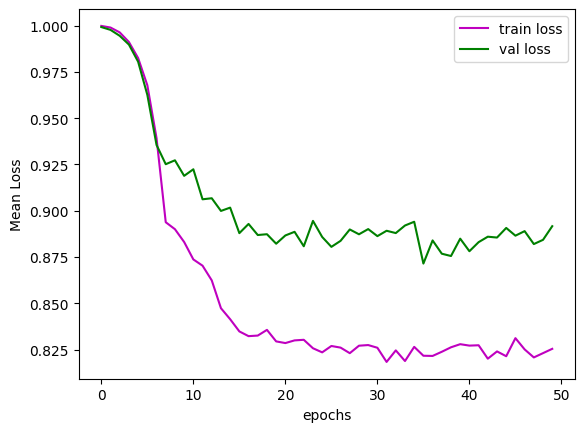

In [ ]:
plt.plot(train_loss_mean, color = 'm')
plt.plot(val_loss_mean, color = 'g')
plt.legend(['train loss', 'val loss'])
plt.xlabel('epochs')
plt.ylabel('Mean Loss')
plt.show()

In [ ]:
results

,classes,precision_mean,recall_mean,f1_mean
0,0,0.807500,0.877000,0.826984
1,1,0.911667,0.886226,0.893674
2,average,0.859583,0.881613,0.860329
